Retrieving USGS data for 01108000 from 2023-10-01 to 2023-12-01
Retrieving NOAA data for GHCND:USW00054777 from 2023-10-01 to 2023-12-01
Requesting NOAA data with parameters: {'datasetid': 'GHCND', 'datatypeid': 'TMAX,TMIN,PRCP', 'stationid': 'GHCND:USW00054777', 'startdate': '2023-10-01', 'enddate': '2023-12-01', 'limit': 1000}
        Date   site_no  00060_Mean 00060_Mean_cd  PRCP   TMAX   TMIN   TAVE  \
0 2023-10-01  01108000       891.0             A   0.0  69.98  50.00  59.99   
1 2023-10-02  01108000       733.0             A   0.0  73.04  44.06  58.55   
2 2023-10-03  01108000       604.0             A   0.0  82.04  41.00  61.52   

   DOY        dr  ...        PEt         PE          W         Y         S  \
0  274  1.000142  ...   8.258643   9.884361  10.000000  4.979528  0.704882   
1  275  1.000710  ...   9.660946  11.562707   0.704882  0.703128  0.071415   
2  276  1.001278  ...  11.819056  14.145641   0.071415  0.071400  0.004351   

         GW       Runoff     Baseflow  

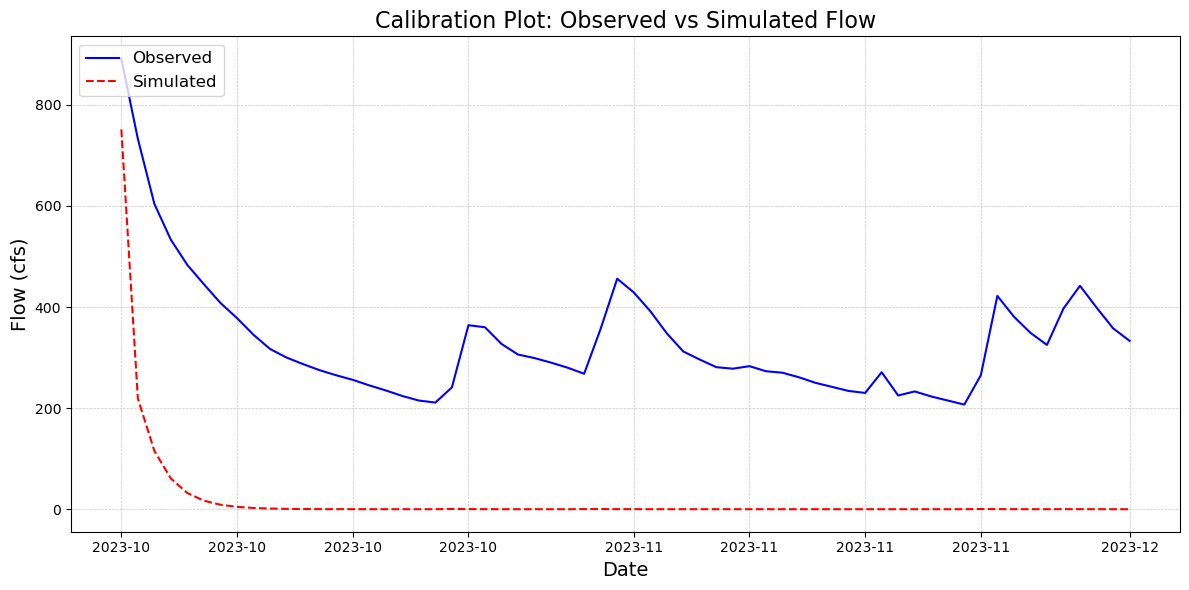

In [74]:
from dataretrieval import nwis  # For USGS data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from math import cos, sin, acos, pi, tan

noaa_site_id= "GHCND:USW00054777"
usgs_site_id="01108000"
start_date = "2023-10-01"
end_date = "2023-12-01"
NOAA_API_TOKEN="lqbBOsoeMwxZbPbaOsZpjdSODFPAqQGG"
a = 0.984560007283129
b = 5.05578448178507
c = 0.710407747560437
d = 0.9
e = 50
Tb = -4.8144232589882
G_init = 2
S_init = 10
lat = 0.732     # radians
Area = 167040 # Acres


def grab_usgs_data(site_no, start_date, end_date):
    """
    Retrieve flow data from USGS.
    :param site_no: USGS site number
    :param start_date: Start date
    :param end_date: End date
    :return: USGS DataFrame
    """
    print(f"Retrieving USGS data for {site_no} from {start_date} to {end_date}")
    df = nwis.get_dv(
        sites=site_no,
        parameterCd="00060",
        statCd="00003",
        start=start_date,
        end=end_date,
    )[0].reset_index()

    df = df.rename(columns={'datetime': 'Date'})
    df['Date'] = df['Date'].dt.tz_convert(None)
    return df

def grab_noaa_data(site_id, start_date, end_date):
    """
    Retrieve climate data from NOAA.
    :param site_id: NOAA site ID
    :param start_date: Start date
    :param end_date: End date
    :return: NOAA Data
    """
    print(f"Retrieving NOAA data for {site_id} from {start_date} to {end_date}")
    # Use the NOAA Climate Data API (example URL)
    NOAA_API_TOKEN="lqbBOsoeMwxZbPbaOsZpjdSODFPAqQGG"

    url = f"https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": NOAA_API_TOKEN}  # Replace with your NOAA API token
    params = {
        "datasetid": "GHCND",            # Global Historical Climatology Network - Daily
        "datatypeid": "TMAX,TMIN,PRCP",       # Request both TMAX and TMIN
        "stationid": site_id,       # Specific station ID
        "startdate": start_date,
        "enddate": end_date,
        "limit": 1000                    # Max records per request
    }
    print(f"Requesting NOAA data with parameters: {params}")
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
    else:
        print("Error:", response.status_code, response.text)

    df = pd.DataFrame(data['results'])
    if not df.empty:
        df = df[['date', 'datatype', 'value']]
        df = df.pivot(index='date', columns='datatype', values='value').reset_index()
        df.columns = ['Date', 'PRCP', 'TMAX','TMIN']
        df['TMAX'] = (df['TMAX'] / 10)*1.8+32
        df['TMIN'] = (df['TMIN'] / 10)*1.8+32
        df['PRCP'] = df['PRCP'] / 10 *0.03937008 # Convert precipitation to millimeters
        df['Date'] = pd.to_datetime(df['Date'])
        df['TAVE'] = (df['TMAX']+df['TMIN'])/2
    else:
        print('grab_noaa_data df is empty')
    return df

usgs_data = grab_usgs_data(usgs_site_id, start_date, end_date)
noaa_data = grab_noaa_data(noaa_site_id, start_date, end_date)


def merge_data(usgs_data, noaa_data):
    # Merge the USGS and NOAA data on 'Date'
    merged_df = pd.merge(usgs_data, noaa_data, on='Date', how='inner')
    merged_df['DOY'] = merged_df['Date'].dt.dayofyear
    return(merged_df)

def model(data, a, b, c, d, e, Tb, lat, S_init, G_init, Area):
    Tave = data['TAVE']
    Tmax = data['TMAX']
    Tmin = data['TMIN']
    Precip = data['PRCP']

    # Day Length Factor (dr)
    data['dr'] = 1 + 0.033 * np.cos(2 * np.pi * data['DOY'] / 365)

    # Solar Declination Angle (del)
    data['del'] = 0.4093 * np.sin((2 * np.pi * data['DOY'] / 365) - 1.405)

    # Solar Hour Angle (ws) in radians
    data['ws'] = np.arccos(-1 * np.tan(data['del']) * np.tan(lat))

    # Hours of sunshine (hrs)
    data['hrs'] = 24 / np.pi * data['ws']

    # Solar Radiation (Sol, in mm/day)
    data['Sol'] = 15.392 * data['dr'] * (
        data['ws'] * np.sin(lat) * np.sin(data['del']) +
        np.cos(lat) * np.cos(data['del']) * np.sin(data['ws'])
    )

    # Potential Evapotranspiration (PEt, in mm/day)
    data['PEt'] = 0.0023 * data['Sol'] * (Tave + 17.8) * np.sqrt(Tmax - Tmin)

    # Actual Evapotranspiration (PE, converted to inches per month)
    data['PE'] = np.where(Tmin < Tb, 0, data['PEt'] / 25.4 * 30.4)

    # Initialize arrays for snow accumulation, snow melt, available water, evapotranspiration opportunity,
    # soil moisture, and groundwater storage
    Snow_acc = np.zeros(len(Tave))
    Snow_melt = np.zeros(len(Tave))
    W = np.zeros(len(Tave))
    Y = np.zeros(len(Tave))
    S = np.zeros(len(Tave))
    GW = np.zeros(len(Tave))

    # Loop through each time step
    for t in range(len(Tave)):
        # Snow model calculations (as implemented before)
        if t == 0:
            Snow_acc[t] = 0
            Snow_melt[t] = min(Snow_acc[t], e * abs(Tave[t] - Tb)) if Tave[t] > Tb else 0
            W[t] = Precip[t] + S_init
            GW[t] = G_init
        elif t < len(Tave) - 1:
            Snow_acc[t] = (Snow_acc[t - 1] + Precip.iloc[t + 1] - Snow_melt[t - 1] 
                           if Tave.iloc[t + 1] < Tb 
                           else Snow_acc[t - 1] - Snow_melt[t - 1])
            Snow_melt[t] = min(Snow_acc[t], e * abs(Tave[t] - Tb)) if Tave[t] > Tb else 0
            W[t] = Precip[t] + S[t - 1]
        else:
            Snow_acc[t] = Snow_acc[t - 1] - Snow_melt[t - 1]
            Snow_melt[t] = min(Snow_acc[t], e * abs(Tave[t] - Tb)) if Tave[t] > Tb else 0
            W[t] = Precip[t] + S[t - 1]

        # Calculate intermediate values w1 and w2
        w1 = (W[t] + b) / (2 * a)
        w2 = W[t] * b / a

        # Calculate Y (evapotranspiration opportunity)
        Y[t] = w1 - np.sqrt((w1 ** 2) - w2)

        # Calculate S (soil moisture)
        S[t] = Y[t] * np.exp(-1 * data['PE'].iloc[t] / b)

        # Calculate GW (groundwater storage)
        if t > 0:
            GW[t] = (c * (W[t] - Y[t]) + GW[t - 1]) / (1 + d)

    # Add calculated columns to the DataFrame
    data['W'] = W
    data['Y'] = Y
    data['S'] = S
    data['GW'] = GW

    # Runoff and Baseflow calculations
    data['Runoff'] = ((1 - c) * (W - Y)) / 12 * Area * 43560 * 7.48 / 1000000  # MG
    data['Baseflow'] = (GW * d) / 12 * Area * 43560 * 7.48 / 1000000  # MG
    data['SimFlow_MG'] = data['Runoff'] + data['Baseflow']
    data['SimFlow_CFS'] = data['SimFlow_MG'] / 0.646 / 30.4  # CFS
    print(data.head(3))
    return data

# Example call
df1 = merge_data(usgs_data, noaa_data)
df2 = model(df1, a, b, c, d, e, Tb, lat, S_init, G_init, Area)


def climate_plot(data):
    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Plot USGS discharge data on the first subplot (ax1)
    ax1.plot(data['Date'], data['00060_Mean'], label='USGS Discharge (cfs)', color='blue', linestyle='--')
    ax1.set_ylabel('Discharge (cfs)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('USGS Discharge Data')
    ax1.grid()

    # Create a second y-axis for precipitation
    ax1_precip = ax1.twinx()
    ax1_precip.bar(data['Date'], data['PRCP'], color='green', alpha=0.5, label='Precipitation (inch)')
    ax1_precip.set_ylabel('Precipitation (inch)', color='green')
    ax1_precip.tick_params(axis='y', labelcolor='green')

    # Reverse the precipitation axis
    ax1_precip.invert_yaxis()

    # Add legends for discharge and precipitation
    ax1.legend(loc='upper left')
    ax1_precip.legend(loc='upper right')

    # Plot NOAA temperature data on the second subplot (ax2)
    ax2.plot(data['Date'], data['TMAX'], color='gray',linestyle='--', label='_nolegend_')
    ax2.plot(data['Date'], data['TMIN'], color='gray',linestyle='--', label='_nolegend_')

    # Fill the area between TMIN and TMAX
    ax2.fill_between(data['Date'], data['TMIN'], data['TMAX'], color='gray', alpha=0.3, label='Temperature Range (TMIN to TMAX)')

    # Plot TAVE on the same subplot
    ax2.plot(data['Date'], data['TAVE'], label='NOAA TAVE (°F)', color='black')

    ax2.set_ylabel('Temperature (°F)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_title('NOAA Temperature Data')

    # Add legends for both subplots
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    # Set the x-axis label
    ax2.set_xlabel('Date')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
  
    return 

def calibration_plot(data):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actual discharge data
    ax.plot(data['Date'], data['00060_Mean'], label='Observed', color='blue', linewidth=1.5)

    # Plot simulated flow data
    ax.plot(data['Date'], data['SimFlow_CFS'], label='Simulated', color='red', linestyle='--', linewidth=1.5)

    # Set plot title and labels
    ax.set_title('Calibration Plot: Observed vs Simulated Flow', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Flow (cfs)', fontsize=14)

    # Format the x-axis for better readability

    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add legend to differentiate between observed and simulated data
    ax.legend(loc='upper left', fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()


calibration_plot(df2)